In [103]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import pandas as pd 

In [104]:
datset_path = '/Users/rivindu/Desktop/DL-A1/Dl-butterfly-Models/Rivindumodel/datset'


In [105]:
# resize images to 244 by 244 and add augmentation techniques

image_height,image_width=244,244
units = 512
learning_rate = 0.001
batch_size = 32
epochs = 10


In [106]:
#augmentation using image Datagenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=[0.5, 1.5],
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    vertical_flip=False, 
    fill_mode='nearest' 
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)



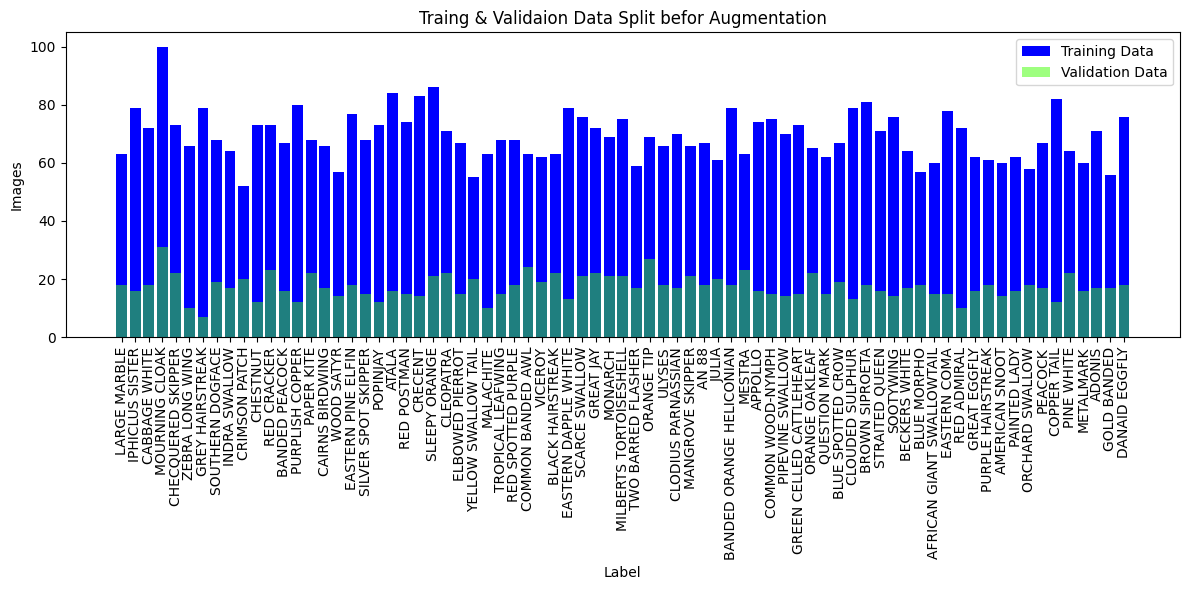

In [107]:
#split dataset to train and validate to monitor over fitting 

image_paths = []
labels = []

for class_folder in os.listdir(datset_path):
    if class_folder == '.DS_Store':
        continue  

    class_path = os.path.join(datset_path, class_folder)
    
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        
        if os.path.isfile(image_path):
            image_paths.append(image_path)
            labels.append(class_folder)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.2, #20% for validaioon
    random_state=42  
)


#visualize dataset
def count_images_per_class(image_paths, labels):
    class_counts = {}
    
    for label in labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1
    
    return class_counts

train_class_counts = count_images_per_class(train_paths, train_labels)
val_class_counts = count_images_per_class(val_paths, val_labels)


class_names_train = list(train_class_counts.keys())
class_counts_train = list(train_class_counts.values())

class_names_val = list(val_class_counts.keys())
class_counts_val = list(val_class_counts.values())


plt.figure(figsize=(12, 6))

# Training graph
plt.bar(class_names_train, class_counts_train, color='blue', label='Training Data')
plt.xlabel('Label')
plt.ylabel('Images')
plt.title('Training Data Class Distribution')
plt.xticks(rotation=90)

# Validation  graph
plt.bar(class_names_val, class_counts_val, color='#3EFF00', label='Validation Data', alpha=0.5)
plt.xlabel('Label')
plt.ylabel('Images')
plt.title('Traing & Validaion Data Split befor Augmentation')
plt.xticks(rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

#create new dataframes for the splits
val_dataframe = pd.DataFrame({'image_paths': val_paths, 'labels': val_labels}) 
train_dataframe = pd.DataFrame({'image_paths': train_paths, 'labels': train_labels})


# Display the number of validation and training data
num_validation_samples = val_dataframe.shape[0]
num_training_samples = train_dataframe.shape[0]



In [108]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_dataframe,
    x_col='image_paths',
    y_col='labels',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_dataframe,
    x_col='image_paths',
    y_col='labels',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 1300 validated image filenames belonging to 75 classes.
Found 5199 validated image filenames belonging to 75 classes.


In [109]:
input_shape = (224, 224, 3)  
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(units, activation='relu')(x)
num_classes = train_dataframe['labels'].nunique()
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [112]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    verbose=1,         
    restore_best_weights=True 
)
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    callbacks=[early_stopping])


val_loss, val_accuracy = model.evaluate(val_generator)


model.save('/Users/rivindu/Desktop/DL-A1/Dl-butterfly-Models/Rivindumodel/mobnetv2.keras')

Epoch 1/10
163/163 [==============================] - 353s 2s/step - loss: 1.7509 - accuracy: 0.5543 - val_loss: 15.1708 - val_accuracy: 0.0254
Epoch 2/10
163/163 [==============================] - 368s 2s/step - loss: 0.8701 - accuracy: 0.7469 - val_loss: 15.4139 - val_accuracy: 0.0315
Epoch 3/10
163/163 [==============================] - 428s 3s/step - loss: 0.6262 - accuracy: 0.8155 - val_loss: 11.6600 - val_accuracy: 0.1223
Epoch 4/10
163/163 [==============================] - 444s 3s/step - loss: 0.5615 - accuracy: 0.8329 - val_loss: 14.7392 - val_accuracy: 0.0792
Epoch 5/10
163/163 [==============================] - 437s 3s/step - loss: 0.5039 - accuracy: 0.8469 - val_loss: 11.8922 - val_accuracy: 0.0608
Epoch 6/10
163/163 [==============================] - 430s 3s/step - loss: 0.4267 - accuracy: 0.8698 - val_loss: 13.5959 - val_accuracy: 0.0738
Epoch 7/10
163/163 [==============================] - 699s 4s/step - loss: 0.3782 - accuracy: 0.8882 - val_loss: 13.6712 - val_accuracy:

/Users/rivindu/Desktop/DL-A1/Dl-butterfly-Models/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [114]:
from tensorflow.keras.preprocessing import image

# Load the image
image_path = '/Users/rivindu/Desktop/testbutterfly/adonis3.png'
img = image.load_img(image_path, target_size=(224, 224))  # Resize the image to (224, 224)

# Convert the image to an array and preprocess it
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = img_array.reshape((1, 224, 224, 3))  # Reshape for model input

# Make predictions
predictions = model.predict(img_array)

import numpy as np

predicted_class_index = np.argmax(predictions)
predicted_class = class_names_train[predicted_class_index]  # Use the class names from your training data


1/1 [==============================] - 1s 670ms/step


In [115]:
print("Predicted class:", predicted_class)


Predicted class: LARGE MARBLE


Using TensorFlow backend


/var/folders/kf/nn9dkw990kg4lrgs7mv3514w0000gn/T/ipykernel_6686/3801807491.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Found 1300 validated image filenames belonging to 75 classes.
Found 5199 validated image filenames belonging to 75 classes.



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.001             |0.001             |learning_rate



Epoch 1/10
  4/163 [..............................] - ETA: 4:11 - loss: 4.4175 - accuracy: 0.0938

KeyboardInterrupt: 